# Проектирование признаков

Далеко не всегда данные находятся в правильном формате ``[`` ``n_samples``, ``n_features`` ``]``.

Потому одним из важнейших этапов использования ML на практике становится ``проектирование признаков (feature engineering)``, т.е. преобразование всей касающейса задачи информации в числа, пригодные для построения матрицы признаков.

Рассмотрим несколько часто встречающихся примеров задач проектирования признаков:

- признаки для представления ``категориальных данных (categorical data)``
- признаки для представления ``текста``
- признаки для представления ``изображений``

И использование ``производных признаков (derived features)`` для повышения сложности модели и заполнения отсутствующих данных. Этот процесс часто называют ``векторизацией``, т.к. он включает преобразование данных в произвольной форме в аккуратные вектроы.

## Категориальные признаки

``категориальные данные (categorical data)`` - один из распространенных типов нечисловых данных.

Например мы анализируем какие-то данные с ценами на жилье, и помимо числовых признаков, таких как цена, площадь, в них так же существуют нечисловые - микрорайон (neighborhood).

In [1]:
data = [
    {'price': 850000, 'rooms': 4, 'neighborhood': 'Queen Anne'},
    {'price': 700000, 'rooms': 3, 'neighborhood': 'Fremont'},
    {'price': 650000, 'rooms': 3, 'neighborhood': 'Wallingford'},
    {'price': 600000, 'rooms': 2, 'neighborhood': 'Fremont'}
]

In [2]:
# Может показаться, что кодировать эти данные следует как словарь
{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

{'Queen Anne': 1, 'Fremont': 2, 'Wallingford': 3}

Но модели SKL исходят из допущения, что числовые признаки отражают алгебраические величины.
Следовательно подобное отображение будет подразумевать:

Queen Anne < Fremont < Wallingford

или даже

Wallingford - Queen Anne = Fremont

что не имеет смысла.

Испытанным методом для такого случая будет ``прямое кодирование (one-hot)`` означающее создание дополнительных столбцов индикаторов наличия/отсутствия категории с помощью значений 1 или 0.

При наличии данных в виде списка словарей для этой цели можно воспользоваться утилитой ``DictVectorizer`` библиотеки SKL.

In [3]:
from sklearn.feature_extraction import DictVectorizer

In [4]:
vec = DictVectorizer(sparse=False, dtype=int)
vec.fit_transform(data)

array([[     0,      1,      0, 850000,      4],
       [     1,      0,      0, 700000,      3],
       [     0,      0,      1, 650000,      3],
       [     1,      0,      0, 600000,      2]])

Столбец *neighborhood* превратился в 3 отдельных столбца.

Чтобы узнать что означает каждый столбец можно посметреть названия признаков:

In [5]:
vec.get_feature_names()

['neighborhood=Fremont',
 'neighborhood=Queen Anne',
 'neighborhood=Wallingford',
 'price',
 'rooms']

У такого подхода есть очивидный недостатое: если кол-во категорий велико - то размер набора данных может значительно вырости.

Однако, поскольку кодирование данных состоит в основном из 0, эффективным решением будет ``разрежанный формат`` вывода:

In [6]:
# sparse - разрежанный
vec = DictVectorizer(sparse=True, dtype=int)
vec.fit_transform(data)

<4x5 sparse matrix of type '<class 'numpy.int32'>'
	with 12 stored elements in Compressed Sparse Row format>

In [7]:
print(vec.fit_transform(data))

  (0, 1)	1
  (0, 3)	850000
  (0, 4)	4
  (1, 0)	1
  (1, 3)	700000
  (1, 4)	3
  (2, 2)	1
  (2, 3)	650000
  (2, 4)	3
  (3, 0)	1
  (3, 3)	600000
  (3, 4)	2


In [8]:
import pandas as pd

In [9]:
pd.DataFrame(data)

,price,rooms,neighborhood
0,850000,4,Queen Anne
1,700000,3,Fremont
2,650000,3,Wallingford
3,600000,2,Fremont


Многие оцениватели SKL допускают передачу им подобных разрежанных данных при обучении и оценке моделей.

Для поддержки подобного кодирования существуют 2 утилиты:
- ``sklearn.preprocessing.OneHotEncoder``
- ``sklearn.feature_extraction.FeatureHasher``

## Текстовые признаки

Часто требуется преобразовать текст в набор репрезентативных числовых значений.

Один из простейщих методов - по *количеству слов*: для каждого фрагмента текста подсчитывается количество вхождений в него каждого из слов, после чего результаты помещаются в таблицу.

In [10]:
sample = ['problem of evil',
          'evil queen',
          'horizon problem']

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer()
X = vec.fit_transform(sample)
X

<3x5 sparse matrix of type '<class 'numpy.int64'>'
	with 7 stored elements in Compressed Sparse Row format>

In [12]:
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,1,0,1,1,0
1,1,0,0,0,1
2,0,1,0,1,0


У такого подхода есть проболемма: подсчет кол-ва слов ведет к большим значениям для признков соответствующих часто встечающимся словам. Для некоторых алгоритмов классификации это можето оказаться субпродуктивным.

Один из подходов к решению этой проблеммы: 
- ``частота термина, обратная частоте документа (term frequency-inverse document frequency)`` или ``TF–IDF``

При таком подходе слова получают вес с учетом частоты их появления во всех документах.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer()
X = vec.fit_transform(sample)
pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

,evil,horizon,of,problem,queen
0,0.517856,0.000000,0.680919,0.517856,0.000000
1,0.605349,0.000000,0.000000,0.000000,0.795961
2,0.000000,0.795961,0.000000,0.605349,0.000000


## Признаки для изображений

Простейший подход - использовать значения интенсивности пикселей. Но он может оказаться неоптимальным для прикладных задач.

Существует библиотека, специализирующийся на анализе изображений ``Scikit-Image``  https://scikit-image.org

### Производные признаки

Ещё один **удобный тип признаков - выведенные математически из каких-либо входных признаков** (``тут мы типа создаем аналитические/расчетные столбцы (доп признаки)``.

**Ранее мы создавали полиномиальные признаки из входных данных.**

Можно преобразовать, например, линейную регрессию в полиномиальную **не меняя модель, а меняя (вычисляя) признаки**

Из предыдущей главы:

------------------------------------------------------------------------------------------------------------------------------
Рассмотрим пример перекрестной проверки для расчета кривой проверки для класса моделей. Используем ``модель полиномиальной регрессии (polynomial regression model)``: это обобщенная линейная модель с параметризованной степенью многочлена.

1я степень $a$ и $b$
$$
y = ax + b
$$

3я степень $a, b, c, d$
$$
y = ax^3 + bx^2 + cx + d
$$

Это можно обобщить на любое кол-во полиномиальных признаков.

В библиотеке SKL реализовать это можно с помощью **простой линейной регрессии в сочетании с полиномиальным препроцессором.**

Воспользуемся ``конвейером (pipeline)`` для соединения этих операций в единую цепочку.

Как это выглядело:

------------------------------------------------------------------------------------------------------------------------------

In [14]:
# from sklearn.preprocessing import PolynomialFeatures
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import make_pipeline

# def PolynomialRegression(degree=2, **kwargs):
#     return make_pipeline(PolynomialFeatures(degree),
#                          LinearRegression(**kwargs))

Такой метод известен как ``регрессия по комбинации базисных ф-ий (basis function regression)``.

Например, очеведно, что следующие данные нельзя адекватно описать с помощью линии:

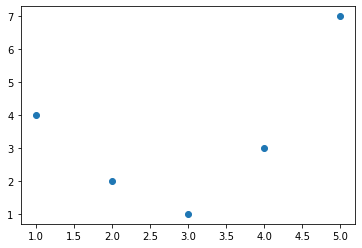

In [15]:
import numpy as np
import matplotlib.pyplot as plt

x = np.array([1, 2, 3, 4, 5])
y = np.array([4, 2, 1, 3, 7])
plt.scatter(x, y)

Тем не менее мы можем подобрать разделяющую линию для этих данных

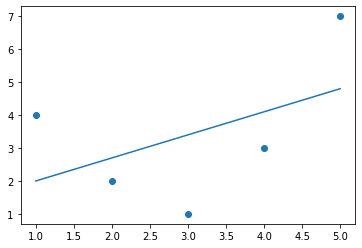

In [16]:
from sklearn.linear_model import LinearRegression
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

Очевидно, что для описания зависимости м/у **x** и **y** нам потребуется более сложная модель.

Сделать это можно путем преобразования данных, добабви дополнительные столбцы признаков для увеличения гибкости модели. 

Добавить в данные полиномиальные признаки можно следующим образом:

In [17]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)
# матрица производных признаков:

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


В матрице производных признаков первый столбец соответствует $x$, второй - $x^2$, а третий - $x^3$.

//*вот только, что-то я не понял, это получается мы не точки берем, а пишем ура-я отрезков, тогда почему их 5?*//

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

sklearn.preprocessing.PolynomialFeatures(degree=2, *, interaction_only=False, include_bias=True, order='C')


Сгенерирует новую матрицу признаков, состоящую из всех полиномиальных комбинаций признаков со степенью, меньшей или равной указанной степени. Например, если входная выборка является двумерной и имеет форму ``[`` $a$, $b$ ``]``, то: 
- полиномиальные признаки степени 2 будут ``[`` $1$, $a$, $b$, $a^2$, $ab$, $b^2$ ``]``

//Тогда почему их 3?*//

###### анука:

In [18]:
X = np.arange(6).reshape(3, 2)
X

array([[0, 1],
       [2, 3],
       [4, 5]])

In [19]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  2.,  3.,  4.,  6.,  9.],
       [ 1.,  4.,  5., 16., 20., 25.]])

In [20]:
poly = PolynomialFeatures(interaction_only=True)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.],
       [ 1.,  2.,  3.,  6.],
       [ 1.,  4.,  5., 20.]])

In [21]:
poly = PolynomialFeatures(3)
poly.fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [22]:
poly = PolynomialFeatures(degree=3)
poly.fit_transform(X)

array([[  1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  1.,   2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  1.,   4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

In [23]:
poly = PolynomialFeatures(degree=3, include_bias=False)
poly.fit_transform(X)

array([[  0.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,   1.],
       [  2.,   3.,   4.,   6.,   9.,   8.,  12.,  18.,  27.],
       [  4.,   5.,  16.,  20.,  25.,  64.,  80., 100., 125.]])

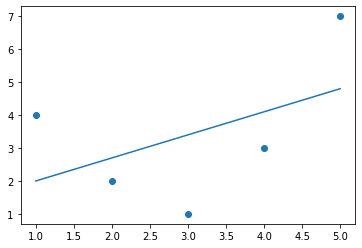

In [24]:
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

In [25]:
X

array([[1],
       [2],
       [3],
       [4],
       [5]])

In [26]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


###### Потому что это ``только для x``    ``не для y``

In [27]:
X = np.array([[0, 1], 
              [0, 2],
              [0, 3],
              [0, 4],
              [0, 5]])

In [28]:
poly = PolynomialFeatures(2)
poly.fit_transform(X)

array([[ 1.,  0.,  1.,  0.,  0.,  1.],
       [ 1.,  0.,  2.,  0.,  0.,  4.],
       [ 1.,  0.,  3.,  0.,  0.,  9.],
       [ 1.,  0.,  4.,  0.,  0., 16.],
       [ 1.,  0.,  5.,  0.,  0., 25.]])

###### как-то так

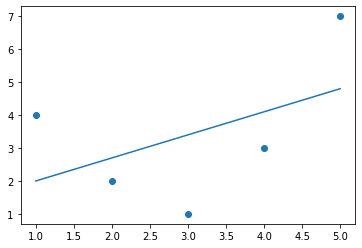

In [29]:
X = x[:, np.newaxis]
model = LinearRegression().fit(X, y)
yfit = model.predict(X)
plt.scatter(x, y)
plt.plot(x, yfit)

In [31]:
poly = PolynomialFeatures(degree=3, include_bias=True) # include_bias=True включать смещение
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.   1.]
 [  1.   2.   4.   8.]
 [  1.   3.   9.  27.]
 [  1.   4.  16.  64.]
 [  1.   5.  25. 125.]]


In [32]:
poly = PolynomialFeatures(degree=3, include_bias=False)
X2 = poly.fit_transform(X)
print(X2)

[[  1.   1.   1.]
 [  2.   4.   8.]
 [  3.   9.  27.]
 [  4.  16.  64.]
 [  5.  25. 125.]]


Расчет линейной регрессии для таких **расширенных** входных данных позволяет получить намного лучшую аппроксимацию:

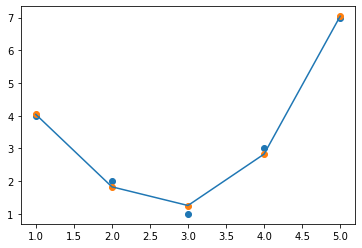

In [34]:
model = LinearRegression().fit(X2, y)
yfit = model.predict(X2)
plt.scatter(x, y)
plt.plot(x, yfit)
plt.scatter(x, yfit)

Идея ``улучшения модели``  ``без изменения модели``, а **путем преобразования входных данных** является базовой для многих более продвинутых методов машинного обучения.
//я такое уже делал оказывается 😊, сам того не подозревая, для аналитики//

В общем случае **это путь к набору обладающих огромными возможностями методик**, известных под названием ``ядерные методы (kernel methods)``.

//ну оно и понятно

## Внесение отсутствующих данных

Еще одна часто встречающаяся задача в проектировании признаков - обработка отсутствующих данных. (которые NaN)

In [35]:
from numpy import nan
X = np.array([[ nan, 0,   3  ],
              [ 3,   7,   9  ],
              [ 3,   5,   2  ],
              [ 4,   nan, 6  ],
              [ 8,   8,   1  ]])
y = np.array([14, 16, -1,  8, -5])

При использовании для подобных данных типичной модели машинного обучения ***необходимо сначала заменить отсутствующие данные каким-либо подходящим значением**.

Это действие называется ``заполнением/вменением (imputation)`` пропущеных значений.

Для реализации простого подхода на основе среднего значения/медианы/моды SKL предлагает класс ``SimpleImputer``

In [36]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='mean')
X2 = imp.fit_transform(X)
X2

array([[4.5, 0. , 3. ],
       [3. , 7. , 9. ],
       [3. , 5. , 2. ],
       [4. , 5. , 6. ],
       [8. , 8. , 1. ]])

In [37]:
# а эти данные уже можно передать оценивателю
model = LinearRegression().fit(X2, y)
model.predict(X2)

array([13.14869292, 14.3784627 , -1.15539732, 10.96606197, -5.33782027])

## Конвейеры признаков

Во всех предыдущих примерах может быстро надоесть выполнять преобразования вручную, особенно если нужно связать цепочкой несколько шагов. Например, нам может понадобиться следующий конвеер обработки:

1. Внести вместо отсутствующих данных средние значения.
2. Преобразовать признаки в квадратичные.
3. Обучить модель линейной регрессии.

Для организации потоковой обработки подобного конвейера библиотека SKL предоставляет объект конвейера, который можно использовать следующим образом:

In [38]:
from sklearn.pipeline import make_pipeline

In [39]:
model = make_pipeline(SimpleImputer(strategy='mean'),
                      PolynomialFeatures(degree=2),
                      LinearRegression())

Этот конвейер выглядит и функционирует аналогично обычному объекту SKL, и выполняет все заданные шаги для любых входных данных.

In [40]:
# массив Х с пропущенными значениями
model.fit(X, y)
print(y)
print(model.predict(X))

[14 16 -1  8 -5]
[14. 16. -1.  8. -5.]


Все шаги этой модели выполняются автоматически. Для простоты демонстрации мы применили модель к тем данным, на которых она была обучена, именно поэтому она смогла хорошо предсказать результат.